In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX 

import pmdarima as pm

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from scipy.stats import boxcox
from scipy.special import inv_boxcox

from tqdm.notebook import tqdm
from itertools import product
from typing import Union

#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'

plt.style.use("seaborn-v0_8-dark")  

-----
## Project: Forecasting the number of antidiabetic drug prescriptions in Australia
------

### 1. Problem Description
------

The objective is to forecast 12 months of antidiabetic drug prescriptions. Use the last 36 months of the dataset as a test set to allow for rolling forecasts.

In [2]:
# Data is provided in a form suitable for Prophet 
df = pd.read_csv('AusAntidiabeticDrug.csv', index_col=0, parse_dates=True)

df.head()

,y
ds,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


In [3]:
df.tail()

,y
ds,
2008-02-01,21.654285
2008-03-01,18.264945
2008-04-01,23.107677
2008-05-01,22.912510
2008-06-01,19.431740


Monthly data from July 1991 to June 2008, 17 years of monthly data 

In [4]:
df.info() # 204 months of data 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 204 entries, 1991-07-01 to 2008-06-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       204 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


In [5]:
# no missing values 

df.isna().sum()

y    0
dtype: int64

In [6]:
df.index

DatetimeIndex(['1991-07-01', '1991-08-01', '1991-09-01', '1991-10-01',
               '1991-11-01', '1991-12-01', '1992-01-01', '1992-02-01',
               '1992-03-01', '1992-04-01',
               ...
               '2007-09-01', '2007-10-01', '2007-11-01', '2007-12-01',
               '2008-01-01', '2008-02-01', '2008-03-01', '2008-04-01',
               '2008-05-01', '2008-06-01'],
              dtype='datetime64[ns]', name='ds', length=204, freq=None)

In [7]:
df.index.freq = 'MS'

### 2. Data Exploration and preperation
------

In [8]:
df.describe()

,y
count,204.000000
mean,10.694430
std,5.956998
min,2.814520
25%,5.844095
50%,9.319345
75%,14.289964
max,29.665356


Data is fairly spread with a mean of roughly 11 prescriptions (or in some appropriate units like thousands etc) per month. 

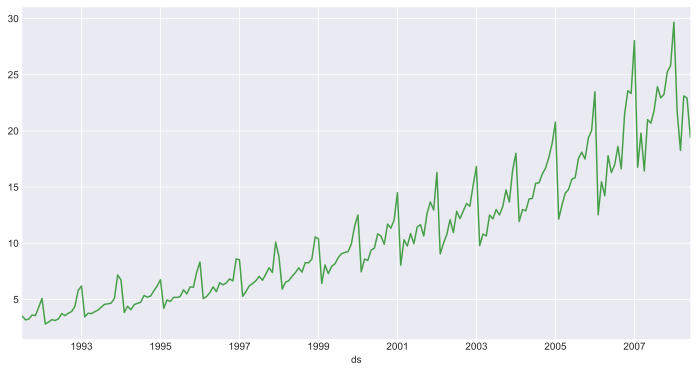

In [9]:
fig, axes = plt.subplots(figsize = (12,6))

df['y'].plot(ax = axes, color = 'green', alpha = 0.7)

axes.grid()

Observations:

- Increasing trend towards recent years 
- Seasonality with an increasing trend, a multplicative seasonal model might perform better 

Lets have a look at STL decomposition to confirm these points. 

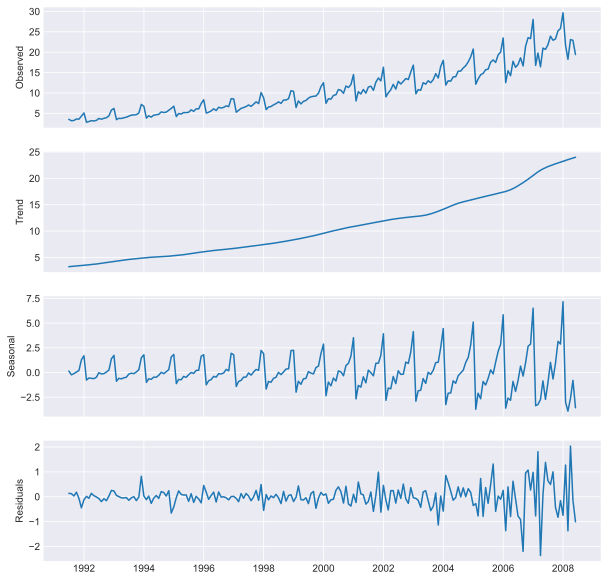

In [10]:
decomp = STL(df['y'], period = 12).fit()

fig, axes = plt.subplots(4,1, figsize = (10,10), sharex=True)

axes[0].plot(decomp.observed)
axes[0].set_ylabel('Observed')

axes[1].plot(decomp.trend)
axes[1].set_ylabel('Trend')

axes[2].plot(decomp.seasonal)
axes[2].set_ylabel('Seasonal')

axes[3].plot(decomp.resid)
axes[3].set_ylabel('Residuals')

for i in range(4):

    axes[i].grid()



We see that trend is increasing with several change points, we can indeed benefit from a prophet like model. Seasonal component has an increasing variance as well towards the later years. Residuals seem to have an increasing variance as well which is likely from the increasing fluctuations in the seasonal component. Lets explore how the data is distributed. 

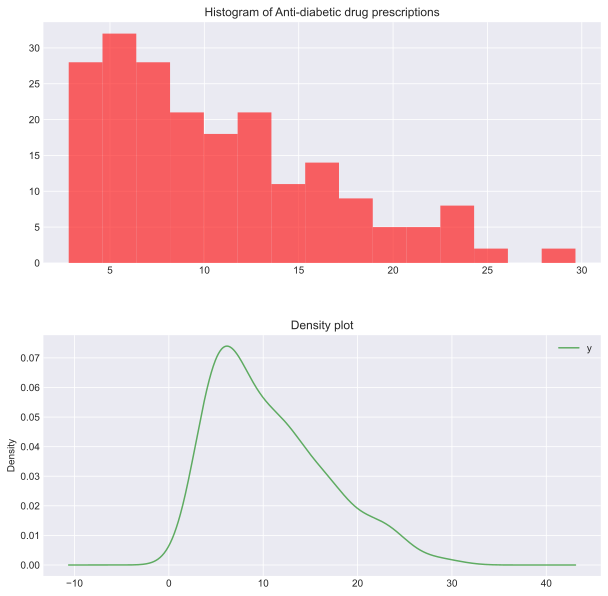

In [11]:
# histogram and density plots 

fig, axes = plt.subplots(2,1,figsize = (10,10))

df.hist(bins = 15, color = 'red', alpha = 0.6, ax = axes[0])
df.plot(kind = 'kde', color = 'green', alpha = 0.6, ax = axes[1])

axes[0].set_title('Histogram of Anti-diabetic drug prescriptions')
axes[1].set_title('Density plot')

axes[1].grid()

Data is left biased, it is not gaussian, could be exponential distribution. It would be a good idea to perform a box-cox transformation before feeding into a statistical model.

In [87]:
fitted_y, fitted_lmbd = boxcox(df['y'])

df['ybc'] = fitted_y

fitted_lmbd

0.061505617726730966

Notice that the fitted $\lambda$ of the box cox x-form is very close to zero implying a log transformation. Lets have a look at the distribution again using the transformed data.

Text(0.5, 1.0, 'Density plot')

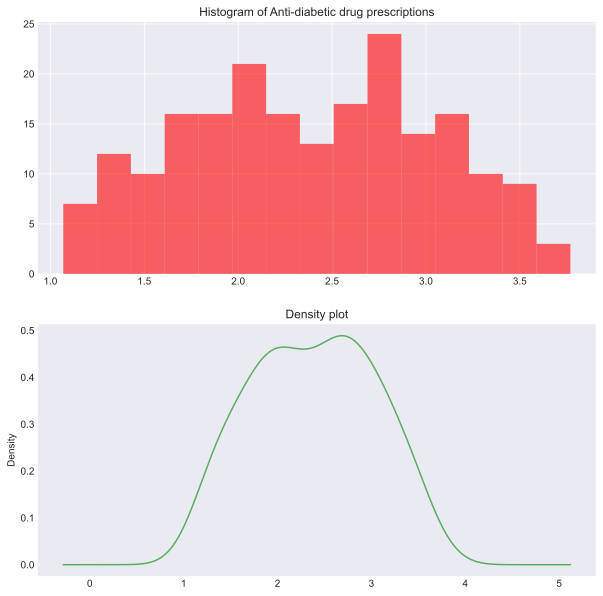

In [13]:
# histogram and density plots 

fig, axes = plt.subplots(2,1,figsize = (10,10))

df['ybc'].hist(bins = 15, color = 'red', alpha = 0.6, ax = axes[0])
df['ybc'].plot(kind = 'kde', color = 'green', alpha = 0.6, ax = axes[1])

axes[0].set_title('Histogram of Anti-diabetic drug prescriptions')
axes[1].set_title('Density plot')

Now the data looks more like a fat Gaussian! We can check the usefulness of the transformation by comparing the qq plot of the original and the transformed data. 

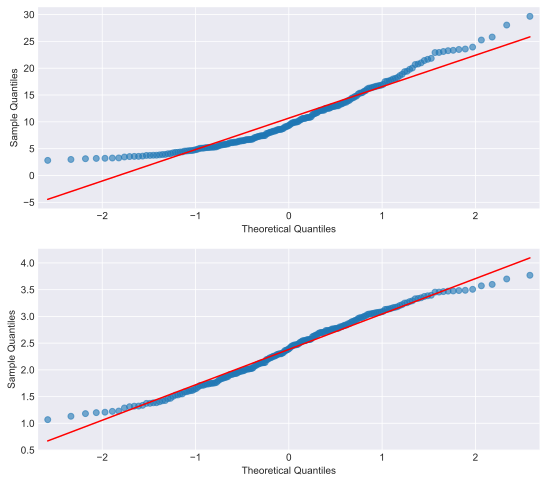

In [14]:
# qq plot of the original data vs box-cox transformed data

fig, axes = plt.subplots(2,1,figsize = (9,8))

qqplot(df['y'], ax = axes[0], alpha = 0.6, line='r');
qqplot(df['ybc'], ax = axes[1], alpha = 0.6, line='r');


axes[0].grid()
axes[1].grid()

The plots above confirm the use of the box-cox transform! In what follows we will work with the transformed data

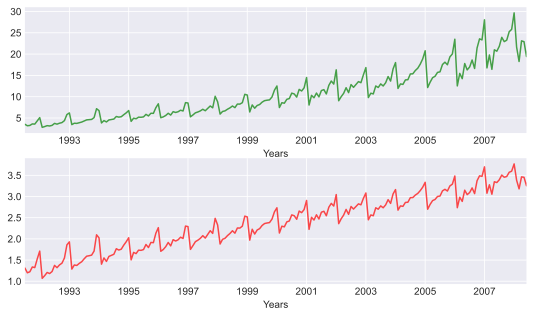

In [15]:
# Finally plot the data again and compare  

fig, axes = plt.subplots(2,1,figsize = (9,5))

df['y'].plot(ax = axes[0], color = 'green', alpha = 0.7)
df['ybc'].plot(ax = axes[1], color = 'red', alpha = 0.7)

for i in range(2):
    axes[i].grid()
    axes[i].set_xlabel('Years')

We observe box-cox transform indeed brought down the larger seasoanl fluctuations roughly to the same scale over the entire dataset!

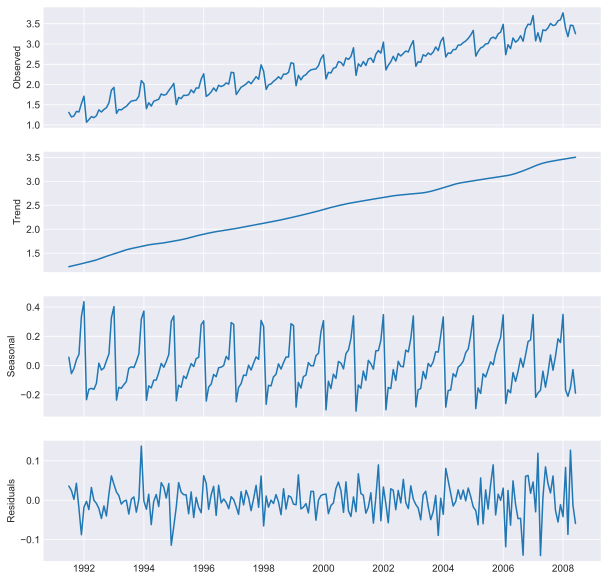

In [16]:
decomp = STL(df['ybc'], period = 12).fit()

fig, axes = plt.subplots(4,1, figsize = (10,10), sharex=True)

axes[0].plot(decomp.observed)
axes[0].set_ylabel('Observed')

axes[1].plot(decomp.trend)
axes[1].set_ylabel('Trend')

axes[2].plot(decomp.seasonal)
axes[2].set_ylabel('Seasonal')

axes[3].plot(decomp.resid)
axes[3].set_ylabel('Residuals')

for i in range(4):

    axes[i].grid()



All our observations so far indicates that a $\textrm{SARIMA(p,d,q)(P,D,Q)}_m$ model (with $m = 12$) would be a good choice to model to the data since the data has trend and seasonal components. We next move on to the model building process in this context to determine model parameters semi-manually. 

### 3. Model Building with SARIMA
------

We first want to determine $d$ and $D$, namely overall trend and seasonal differencing we need to implement to render the data stationary. Recall that SARIMA models work best with stationary data. Of course we can automatically determine all the model parameters $p,d,q,P,D,Q$ using `auto_arima()` method from the pmd arima library which automatically choses the best model accounding to `AIC` criterion.  



#### Augmented Dicky-Fuller, ACF and PACF
------


In [17]:
# Helper function to decide if the series is stationary or not!

def adf(x): # Note that the null hypothesis is that the TS is non-stationary

    test, p_val, *_ = adfuller(x.dropna())

    print(f"ADF test statistic: {test:.5f}")
    print(f"ADF p-value: {p_val:.5f}")

    if p_val < 0.05:
        print('Time-series is stationary!')
    else:
        print('Time-series is not stationary!')

In [18]:
adf(df['ybc']) # undifferenced data is not stationary as expected 

ADF test statistic: -0.58116
ADF p-value: 0.87518
Time-series is not stationary!


In [19]:
# Check first differencing with previous vals 

diff_y = df['ybc'].diff(1)

adf(diff_y)

ADF test statistic: -3.83609
ADF p-value: 0.00256
Time-series is stationary!


In [20]:
# Check first differencing + seasonal differincing 

diff_y_season = df['ybc'].diff(1).diff(12)

adf(diff_y_season)

ADF test statistic: -4.80589
ADF p-value: 0.00005
Time-series is stationary!


We see that first differencing will already rendered the series stationary. We might expect this because we already flattened large seasonal fluctuations by box-cox transform which in turn removed the variance in the seasonal component of the series. Therefore we may choose to work with a $d = 1$, $D = 0$ or $d = 1$, $D = 1$ SARIMA model. 

In [21]:
# Checking the stationarity of the seasonal component of the box-cox transformed series confirm our findings above 

adf(decomp.seasonal)

ADF test statistic: -11.19196
ADF p-value: 0.00000
Time-series is stationary!


#### SARIMA model Selection
------
Now we have determined possible choices of $d$ and $D$, we can move on to the optimizing $p,q$ and $P,Q$. For this purpose we will use a helper function that will make a grid search of possible $p,q,P,Q$ values and sort the associated SARIMA models according to their `AIC`

In [22]:
p_vals = range(0,4,1)
q_vals = range(0,4,1)
P_vals = range(0,4,1)
Q_vals = range(0,4,1)

order_list = list(product(p_vals,q_vals,P_vals,Q_vals)) # all possible tuples of (p,q,P,Q) within the specified range 

In [26]:

def auto_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:

    results = list()

    for order in tqdm(order_list):

        try:

            model= SARIMAX(endog, exog, order = (order[0], d, order[1]), seasonal_order=(order[2],D,order[3],s), simple_differencing=False)
            model_fit = model.fit(disp = False)

        except:
            continue

        aic = model_fit.aic
        results.append([order, aic])

    res_df = pd.DataFrame(results)
    res_df.columns = ['(p,q,P,Q)', 'AIC']

    # Sort in ascending order of AIC

    res_df = res_df.sort_values(by = 'AIC', ascending=True).reset_index(drop = True)

    return res_df

In [23]:
# Before optimizing the model parameters, first train test split where we keep last 36 months as the test data 

N_test = 36
train, test = df['ybc'][:-N_test], df['ybc'][-N_test:]

print(f'Length of the test series is: {len(test)}')

Length of the test series is: 36


In [24]:
# to suppress convergence warnings 

import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [28]:
# check Model with different seasonal differencing D = 0 or D = 1

d = 1
s = 12

auto_SARIMAX(train, None, order_list, d, 0, 12)

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 3, 1, 2)",-424.674815
1,"(0, 1, 1, 2)",-424.387322
2,"(0, 1, 3, 1)",-423.418697
3,"(0, 1, 2, 1)",-422.550121
4,"(1, 1, 1, 2)",-422.452899
...,...,...
251,"(0, 1, 0, 0)",-79.203002
252,"(3, 0, 0, 0)",-74.521054
253,"(2, 0, 0, 0)",-72.897427
254,"(1, 0, 0, 0)",-65.925232


Best model with $D = 0 (d = 1)$ has $p = 2, q = 3, P = 1, Q = 2$. However notice that a much simpler model with $p = 0, q = 1, P = 1, Q = 2$ has almost the same `AIC` with the best performing one. Lets check the case with D = 1 (and d = 1). 

In [29]:
# D = 1

auto_SARIMAX(train, None, order_list, d, 1, 12)

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 3, 0, 2)",-422.869679
1,"(3, 3, 1, 1)",-421.542745
2,"(2, 3, 0, 2)",-421.401845
3,"(2, 3, 1, 1)",-421.280687
4,"(3, 3, 2, 1)",-421.226857
...,...,...
251,"(0, 0, 3, 0)",-337.655776
252,"(0, 0, 0, 1)",-322.637711
253,"(0, 0, 2, 0)",-319.249140
254,"(0, 0, 1, 0)",-311.472382


Comparing different choices of $D$ we performed, we that the seasonally undifferenced model perform better than the differenced one with $D = 1$. Note that both models have the same amount of parameters: $p + q + D + Q = 8$. However there is a simpler version of the seasonally undifferenced model, that has $p + q + D + Q = 4$ with $p = 0, q = 1, P = 1, Q = 2$ and with slightly lower `AIC` as compared to the best model. Therefore we will focus on the simpler model that has 4 less parameters: SARIMA(0,1,1)(1,0,2)!

#### Residual analysis
-----

Now we have selected the best model, we move on to check the distribution of the residuals to ensure that we do not fool ourselves with this selection. For this purpose we fit the selected model on the training set and make diagnostic plots of the residuals first.

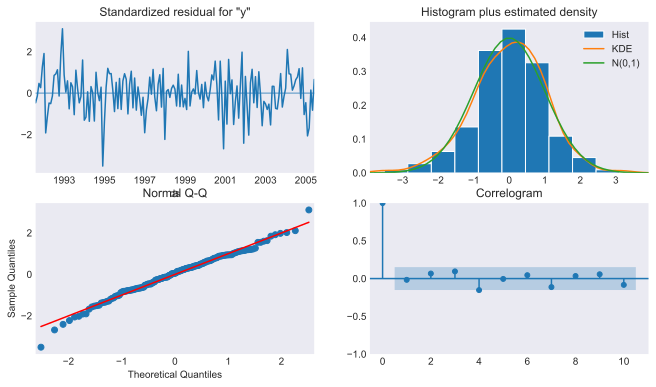

In [123]:
sarima_model = SARIMAX(train, order = (0,1,1), seasonal_order=(1,0,2,12), simple_differencing=False)

sarima_fit = sarima_model.fit(disp = False)

sarima_fit.plot_diagnostics(figsize = (11,6));

Residuals are as Gaussian as they can be closely resembling a white noise with no correlation! Lets make this statsment more quantitative by Ljung-Box test which determines whether the residuals are uncorrelated and independent. The null hypothesis is that the residuals are uncorrelated, just like white noise. If we get p-values more than 0.05 we can not reject the null hypotesis and conclude that indeed residuals are white noise.  

In [125]:
resids = sarima_fit.resid

df_ljungbox = acorr_ljungbox(resids, lags=np.arange(1,6,1))

df_ljungbox

,lb_stat,lb_pvalue
1,0.104461,0.746541
2,0.243805,0.885235
3,0.677765,0.878421
4,1.311972,0.859341
5,2.214268,0.818772


All p-values up-to lag 5 is larger than 0.05!

### 4. Evaluation of the model's performence and Forecasts
------

We have a model that can be used for forecasting, so we’ll now perform rolling forecasts of 12 months over the test set of 36 months. That way we’ll have a better evaluation of our model’s performance, as testing on fewer data points might lead to skewed results. We’ll use the naive seasonal forecast as a baseline; it will simply take the last 12 months of data and use them as forecasts for the next 12 months.

In [129]:
# helper function to perform rolling forecasts of a specified window and horizon. Here the horizon will be the entire test set and the window will be 12 

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window:int, method: str) -> list:

    total_len = train_len + horizon # total length of the entire dataset 
    end_idx = train_len # the index after which we start our forecasts

    if method == 'naive': # naive forecast 

        pred = []

        for i in range(train_len, total_len, 1): # we stay in the loop 36 times 

            fcast = df.iloc[i-1]['y'] # for each iteration we assign the last known val to the prediction

            pred.extend(fcast for _ in range(1))

        return pred   

    if method == 'naive_season': # naive seasonal forecast 

        pred_ns = []

        for i in range(train_len, total_len, window): # we stay in the loop for 3 i vals excluding the last index 204 

            ns_fcast = df['y'][i-window:i].values # for each index i = 168, 180, 192 set the fcast to be the val 12 months prior 

            pred_ns.extend(ns_fcast)

        return pred_ns 

    elif method == 'SARIMA':

        pred_sarima = []

        for i in range(train_len, total_len, window):

            bxcx_train, lmbd = boxcox(df['y'][:i])
            
            if lmbd < -5:
                
             bxcx_train, lmbd = df['y'][:i].to_numpy(), 1

            model = SARIMAX(bxcx_train, order = (0,1,1), seasonal_order = (1,0,2,12), simple_differencing=False)

            model_fit = model.fit(disp = False)

            t_preds = model_fit.get_prediction(0, i + window - 1)

            at_preds = t_preds.predicted_mean[-window:] # take last 12 of the predictions 

            preds = inv_boxcox(at_preds, lmbd)

            pred_sarima.extend(preds) # append them 

        return pred_sarima

In [130]:
df_preds = df[-N_test:][['y']]

In [131]:
T_LEN = 168
HORIZON = 36
WINDOW = 12

naive = rolling_forecast(df, T_LEN, HORIZON, WINDOW, 'naive')
naive_seasonal = rolling_forecast(df, T_LEN, HORIZON, WINDOW, 'naive_season')
sarima_fcast = rolling_forecast(df, T_LEN, HORIZON, WINDOW, 'SARIMA')

df_preds['naive_fcast'] = naive
df_preds['naive_s_fcast'] = naive_seasonal
df_preds['sarima_fcast'] = sarima_fcast

In [119]:
df.index[168]

Timestamp('2005-07-01 00:00:00', freq='MS')

Text(0.5, 0, 'Date')

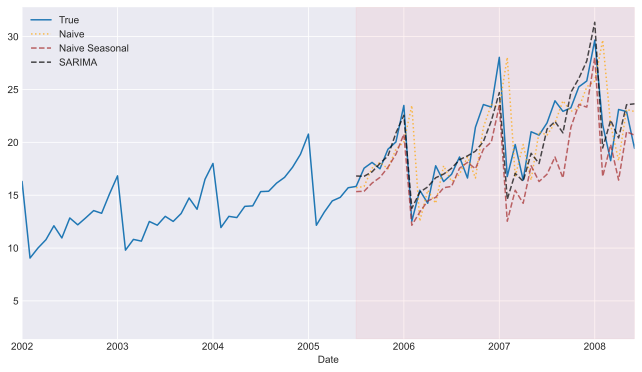

In [132]:
fig, axes = plt.subplots(figsize = (11,6))

df['y'].plot(ax = axes, label = 'True')

df_preds['naive_fcast'].plot(ax = axes, color = 'orange', alpha = 0.7, ls = 'dotted', label = 'Naive')
df_preds['naive_s_fcast'].plot(ax = axes, color = 'brown', alpha = 0.7, ls = 'dashed', label = 'Naive Seasonal')
df_preds['sarima_fcast'].plot(ax = axes, color = 'black', alpha = 0.7, ls = 'dashed', label = 'SARIMA')

axes.set_xlim('2002', '2008-06')
axes.axvspan(df.index[168],df.index[203], color = 'red', alpha = 0.05)
axes.legend()
axes.grid()
axes.set_xlabel('Date')


Notice that SARIMA predictions follows the actual values closer than the naive seasonal forecast! And of course the naive predictions are just lagged values! The make these statements quantitative we will use MAPE and compare. 

In [133]:
sarima_mape = mean_absolute_percentage_error(df_preds.sarima_fcast, df_preds.y) * 100
ns_mape = mean_absolute_percentage_error(df_preds.naive_s_fcast, df_preds.y) * 100
n_mape = mean_absolute_percentage_error(df_preds.naive_fcast, df_preds.y) * 100

print(f"Test MAPE for naive, naive seasonal vs SARIMA forecast: {n_mape:.3f}, {ns_mape:.3f} vs {sarima_mape:.3f} percent")


Test MAPE for naive, naive seasonal vs SARIMA forecast: 13.383, 15.305 vs 7.983 percent


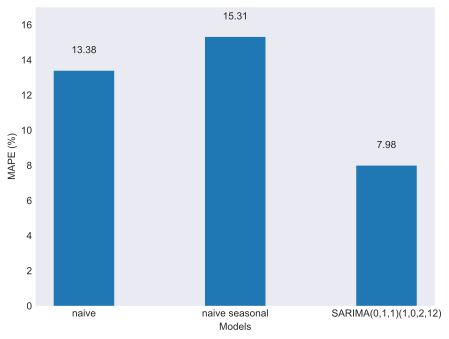

In [134]:
# bar plots for different mapes 

fig, ax = plt.subplots()

x = ['naive', 'naive seasonal', 'SARIMA(0,1,1)(1,0,2,12)']
y = [n_mape, ns_mape, sarima_mape]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 17)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()


### Extensions
-------

- We can try to best performing model with the slightly lower `AIC` to see if it improves the model performence on the test set. Recall that this model was much more complex, so if it performs much better than the simpler model we focused here, it would be good trade-off. 

- As we have seen when we made the STL decomposition of the data, trend has shown many change points which could be flexibly modeled by Prophet type model. The latter is also pretty efficient in modeling seasonality that seem to be multiplicative over the trend as we realized in the raw data. 